<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 8th exercise: <font color="#C70039">Work with a regular Generative Adversarial Network (GAN)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Marvin Reuter
* Matriculation number: 11139466
* Date:   13.11.2024

<img src="https://www.researchgate.net/publication/338509383/figure/fig1/AS:845792709464064@1578664104008/Overview-of-generative-adversarial-network-GAN.ppm" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
The code implements a regular GAN that generates images using a random latent vector as input. While it works great we do not know the mapping of latent vector to the generated image.

Conditional GANs, however, can be used to supply a label during taining so the latent vector can be associated with a specific label - making the generation of images predictable. 

The below coded GAN is using the so-called cifar10 data set, which is standard to many machine learning applications (60,000 32x32 color images in 10 different classes: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
Following the code trains and generates images based on that cifar10 data set, that is included in the Keras package. 
Further information on the data set can be found here: <a href="https://en.wikipedia.org/wiki/CIFAR-10"> cifar10 data set (wiki)</a>

The code is adapted from the code by Jason Brownlee from his blogs on <a href="https://machinelearningmastery.com/">https://machinelearningmastery.com/</a>.
I seriously urge everyone to follow his blogs and get inspired. Hence, original credit goes to Jason Brownlee. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. train the GAN with a higher dimension of the latent space and over more epochs. Are the results improving? 
5. What could be done to further improve the quality of the generated images? 
---------------------------------

### GAN
#### Imports

In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.cifar10 import load_data

# this import is needed because there is a problem with the Secure Socket Layer (SSL) certificate, 
# It can be resolved using the below line of code
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Build the GAN architeture

Use the "functional" way of defining the model for the conditional gan but use "sequential" for descriminator and generator as they are straight forward.

#### Define the standalone discriminator model

Given an input image, the Discriminator outputs the likelihood of the image being real.
Binary classification - true or false (1 or 0). So use the sigmoid activation.

In [2]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="discriminator")

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    
    # Compile model since it is going to be trained directly and choose the optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)               

#### Define the standalone generator model
Given the latent vector input, the Generator produces an image.(here: 32x32)
The latent_dim, for example, can be 100, 1D array of size 100. 

Only Dense and conv2dlayers are being used. But the network can be more complicated based on the problem you are trying to solve. For example, you can use VGG as the basis for a super resolution GAN. 

In [3]:
#latent_dim is the dimension of the latent vector (e.g., 100 - see below)
def define_generator(latent_dim):    
    
    model = Sequential(name="generator")

    # Reshape the input latent vector into an 8x8 image as a starting point. 
    # Hence n_nodes for the Dense layer are e.g. 128x8x8, so when reshaping the output 
    # it would be 8x8x128 and that can be slowly upscaled to a 32x32 image as the output.
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with a 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 data set from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  # the generator model not compiled as it is not directly trained as the discriminator.
                  # the generator is being trained via a GAN combined model (see below)

test_generator = define_generator(latent_dim=100)
print(test_generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                               

Now, define the combined generator and discriminator model, for updating the generator.
The discriminator is trained separately so here only the generator will be trained by keeping the discriminator constant. 

In [4]:
def define_gan(generator, discriminator):
    # The discriminator is trained separately (see above). Hence, set it to not trainable.
    discriminator.trainable = False  
    
    # Now, connect the generator and the discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # Compile the combined model and Choose an optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

### Load data
Load the data set and plot parts of it in order to get a quick understanding.

CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

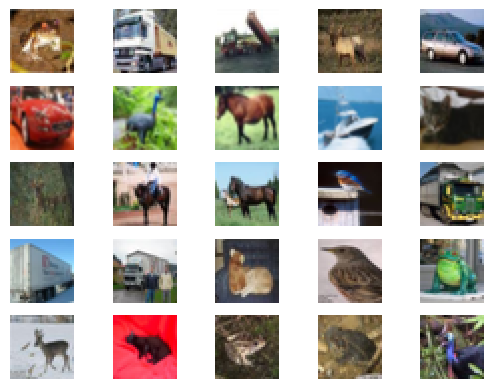

In [5]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25=5x5 example images
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [6]:
# Load the cifar images and build a training data set
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # convert to float and scale.
    X = trainX.astype('float32')
    # the generator uses tanh as activation function (see above), 
    # so we need to rescale from [0,255] to [-1,1]
    # original images to -1 to 1 to match the output of generator.
    X = (X - 127.5) / 127.5  
    
    return X

In [7]:
# Pick a batch of random real samples to train the GAN
# In fact, train the GAN on a half batch of real images and another half batch of fake images. 
# For each real image assign the label=1 and for fake assign the label=0. 
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    x = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) # label=1 indicates that the image is a real one
    return x, y

In [8]:
# Generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# Use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    x = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  # label=0 indicates that the image is a fake one
    return x, y

### Training function for the generator and discriminator
Loop through a number of epochs to train the discriminator by first selecting a random batch of images from the true/real data set. Then, generate a set of images using the generator. Feed both sets of images into the discriminator. Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

In [10]:
def train(g_model, d_model, gan_model, filename, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
            #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples as valid ones.
            # This is where the generator is trying to trick discriminator into believing that 
            # the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # The generator is part of the combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if the generator did a great
            # job of fooling the discriminator, then the output would be 1 (true).
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch=',i+1, 'Batch=', j+1, '/',bat_per_epo, 'd1=', d_loss_real, 'd2=', d_loss_fake, 'g=', g_loss)
    
    # save the generator model
    g_model.save(filename)

### Train the GAN

In [11]:
# size of the latent space
latent_dim =640
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
n_epochs=10 #50
model_filename = "cifar_GAN." + str(n_epochs) + "_epochs.keras"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)

2/2 [==============================] - 1s 95ms/step
Epoch= 1 Batch= 1 / 390 d1= 0.7287912368774414 d2= 0.6950054168701172 g= 0.691871166229248
2/2 [==============================] - 0s 80ms/step
Epoch= 1 Batch= 2 / 390 d1= 0.6520925164222717 d2= 0.7093974351882935 g= 0.6787703037261963
2/2 [==============================] - 0s 82ms/step
Epoch= 1 Batch= 3 / 390 d1= 0.5899285674095154 d2= 0.7289202213287354 g= 0.6633892059326172
2/2 [==============================] - 0s 80ms/step
Epoch= 1 Batch= 4 / 390 d1= 0.5556963086128235 d2= 0.7582241296768188 g= 0.6438986659049988
2/2 [==============================] - 0s 80ms/step
Epoch= 1 Batch= 5 / 390 d1= 0.5053403377532959 d2= 0.7878990769386292 g= 0.6299686431884766
2/2 [==============================] - 0s 70ms/step
Epoch= 1 Batch= 6 / 390 d1= 0.4661123752593994 d2= 0.81797194480896 g= 0.6173608303070068
2/2 [==============================] - 0s 90ms/step
Epoch= 1 Batch= 7 / 390 d1= 0.43981045484542847 d2= 0.8485903143882751 g= 0.62942802906

1/1 [==============================] - 0s 124ms/step


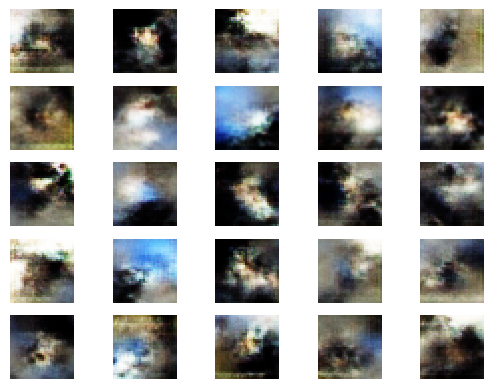

In [13]:
# Now, load the generator model and generate images

# Plot generated images function
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

# load model
model = load_model(model_filename) #Model trained for n epochs

# generate the latent vector 
latent_points = generate_latent_points(latent_dim, 25)  #Latent dim and n_samples

# generate images from the latent vector 
X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the generated images
# Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
show_plot(X, 5)